In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import numpy as np
from IPython.core.display_functions import display
from PIL import Image as pilimg
from tensorflow import keras
import coremltools as ct
import sklearn
from tqdm.notebook import tqdm


if os.getcwd().startswith("/Users"): os.chdir(os.getcwd().split("/notebooks", 1)[0])

from src.config.notebook_config import NotebookConfig
from src.visualisations import image_plot
from src.utils.image_processor import ImageProcessor

from src.evaluation.evaluation import Evaluation

from src.data.utility.tf_dataset_transformer import TfDatasetTransformer


%load_ext autoreload
%autoreload 2

# Conversion of a tensorflow model to CoreML

This notebook's purpose it to convert a keras SavedModel to a CoreML model.

In [2]:
MODEL_NAME = "model_5"

import src.data.dataset.dataset_v3_loader as dataset_loader # V3
config = NotebookConfig(MODEL_NAME, dataset_loader.dataset_name())

val_dataset = dataset_loader.load_validation_v3()
image_processor = ImageProcessor(image_target_size=config.image_size)

In [3]:
model_path = config.saved_model_path
model_tf = keras.models.load_model(model_path, compile=False)
model_tf.compile()

print(f"Loaded model from '{model_path}'")

Loaded model from './models/tensorflow/model_5_v3'


## Model Part 1 - Image Features Extraction

This is the part of the model that is used on both images in the siamese network.

- First we analyze the layers to determine which ones we need in the CoreML network.
- Then we create a new keras model from it
- Finally we convert it to CoreML.

#### Part 1 - Analysis

In [33]:
model_tf.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_18 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_4 (Functional)           (None, 1280)         4226432     ['input_17[0][0]',               
                                                                  'input_18[0][0]']         

In [34]:
model_tf.layers[2].summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resize_image_to_fit_4 (Resi  (None, 224, 224, 3)      0         
 zeImageToFit)                                                   
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 1280)              1230080   
                                                                 
Total params: 4,226,432
Trainable params: 1,230,080
Non-trainable params: 2,996,352
_________________________________________________________________


In [35]:
model_tf.layers[2].layers[-1].get_config()

{'name': 'dense_8',
 'trainable': True,
 'dtype': 'float32',
 'units': 1280,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

#### Part 1 - Create Keras Model

In [36]:
layers = model_tf.layers[2].layers[2:]

input = keras.layers.Input(shape=config.image_shape.to_shape(), name="input_model_part_1")
model_part_1 = input

for layer in layers:
    model_part_1 = layer(model_part_1)

model_part_1 = keras.models.Model(inputs=input, outputs=model_part_1)

In [37]:
model_part_1.summary()
model_part_1.compile()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_model_part_1 (InputLa  [(None, 224, 224, 3)]    0         
 yer)                                                            
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 1280)              1230080   
                                                                 
Total params: 4,226,432
Trainable params: 1,230,080
Non-trainable params: 2,996,352
_________________________________________________________________


#### Part 1 - Convert Model

In [73]:
coreml_model_part_1 = ct.convert(
    model_part_1, inputs=[ct.ImageType()],
)

display(coreml_model_part_1)

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 729/729 [00:00<00:00, 1530.27 ops/s]


input {
  name: "input_model_part_1"
  type {
    imageType {
      width: 224
      height: 224
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 224
          upperBound: 224
        }
        heightRange {
          lowerBound: 224
          upperBound: 224
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.8.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.2.0"
  }
}

In [13]:
coreml_model_part_1.save(config.core_ml_path(1))

### Part 1 - Test Making Predictions

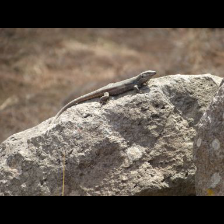

In [101]:
image_a = val_dataset.load_image(500)[0]
image_b = val_dataset.load_image(500)[1]

image_a = image_processor.fit_resize(image_a)
image_b = image_processor.fit_resize(image_b)

image_a

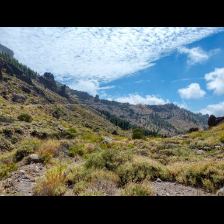

In [102]:
image_b

In [103]:
pred_a = model_part_1.predict(np.expand_dims(np.array(image_a), axis=0))
pred_b = model_part_1.predict(np.expand_dims(np.array(image_b), axis=0))

pred_a[pred_a != 0]

array([81.57129  ,  0.8707111, 36.358746 ,  1.1065607, 72.117134 ,
       47.280907 ], dtype=float32)

In [104]:
pred_coreml_a = coreml_model_part_1.predict(data={"input_model_part_1" : image_a})["Identity"]
pred_coreml_b = coreml_model_part_1.predict(data={"input_model_part_1" : image_b})["Identity"]

In [105]:
diff_models = pred_a - pred_coreml_a
diff_models[diff_models != 0]

array([2.1417851, 2.1289415, 3.0425558, ..., 2.4752183, 2.6469908,
       2.211713 ], dtype=float32)

In [106]:
# Distance between images with the original split model
distance_img_vector = pred_a - pred_b

display(distance_img_vector[distance_img_vector != 0])
display(np.sqrt(np.sum(distance_img_vector * distance_img_vector)))

array([-18.404495, -20.5761  , -24.328823, -54.32293 ,  48.291508,
         4.580036], dtype=float32)

81.596695

In [107]:
# Distance between images with the converted model
distance_img_vector = pred_coreml_a - pred_coreml_b

display(distance_img_vector[distance_img_vector != 0])
display(np.sqrt(np.sum(distance_img_vector * distance_img_vector)))

array([ 0.00431728,  0.251801  , -0.63183784, ...,  0.53454137,
       -0.65410054, -0.4499656 ], dtype=float32)

88.173096

# Model Part 2 - Similarity

#### Part 2 - Create Keras Model

In [38]:
layers = model_tf.layers[-2:]

#Input2 => 2 are needed!!!
input = keras.layers.Input(shape=model_part_1.layers[-1].output_shape[1:], name="input1_model_part_2")
input2 = keras.layers.Input(shape=model_part_1.layers[-1].output_shape[1:], name="input2_model_part_2")
model_part_2 = [input, input2]

for layer in layers:
    model_part_2 = layer(model_part_2)

model_part_2 = keras.models.Model(inputs=[input, input2], outputs=model_part_2, name="model_part_2")

In [39]:
model_part_2.summary()

Model: "model_part_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1_model_part_2 (InputLaye  [(None, 1280)]      0           []                               
 r)                                                                                               
                                                                                                  
 input2_model_part_2 (InputLaye  [(None, 1280)]      0           []                               
 r)                                                                                               
                                                                                                  
 euclidian_distance (EuclidianD  (None, 1)           0           ['input1_model_part_2[0][0]',    
 istance)                                                         'input2_model_part_2[

#### Part 2 - Convert Model

In [40]:
coreml_model_part_2 = ct.convert(
    model_part_2,
)

display(coreml_model_part_2)

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 12/12 [00:00<00:00, 11629.31 ops/s]


input {
  name: "input1_model_part_2"
  type {
    multiArrayType {
      shape: 1
      shape: 1280
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          lowerBound: 1
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 1280
          upperBound: 1280
        }
      }
    }
  }
}
input {
  name: "input2_model_part_2"
  type {
    multiArrayType {
      shape: 1
      shape: 1280
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          lowerBound: 1
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 1280
          upperBound: 1280
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.8.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.2.0"
  }
}

In [42]:
coreml_model_part_2.save(config.core_ml_part2_path)

# Evaluation of Converted Model

In [3]:
model_part1 = ct.models.MLModel(config.core_ml_part1_path)
model_part2 = ct.models.MLModel(config.core_ml_part2_path)

In [4]:
img_processor = ImageProcessor(image_target_size=config.image_size)

def predict(img_a: pilimg.Image, img_b: pilimg.Image, model_part_1: ct.models.MLModel, model_part_2: ct.models.MLModel) -> float:
    output_1_a = model_part_1.predict({"input_model_part_1" : img_a})["Identity"]
    output_1_b = model_part_1.predict({"input_model_part_1" : img_b})["Identity"]

    return model_part_2.predict({"input1_model_part_2" : output_1_a, "input2_model_part_2" : output_1_b})["Identity"]


In [ ]:
classifications_coreml: list[float] = []

for image_label_pair in tqdm(val_dataset.image_pairs):
    image_a = img_processor.fit_resize(pilimg.open(image_label_pair.image_a))
    image_b = img_processor.fit_resize(pilimg.open(image_label_pair.image_b))
    is_similar = image_label_pair.similar

    result_coreml = predict(image_a, image_b, model_part1, model_part2)

    classifications_coreml.append(result_coreml)

classifications_coreml: np.ndarray = np.array(classifications_coreml)

  0%|          | 0/29491 [00:00<?, ?it/s]

In [ ]:
classifications_tf: np.ndarray = model_tf.predict(TfDatasetTransformer(image_shape=config.image_shape).transform_to_tf_dataset(val_dataset))

In [60]:
augmented = np.fromiter(map(lambda pair: pair.augmented, val_dataset.image_pairs), dtype=bool)
similar = np.fromiter(map(lambda pair: pair.similar, val_dataset.image_pairs), dtype=bool)


print("Classification report for Keras model.")
print("--------------------------------------")
print(sklearn.metrics.classification_report(classifications_tf > 0.5, augmented))

print("Classification report for Keras model - Only Original")
print("--------------------------------------")
indices = augmented == False
print(sklearn.metrics.classification_report(classifications_tf[indices] > 0.5, similar[indices], zero_division=0))

print("Classification report for Keras model - Only Augmented")
print("--------------------------------------")
indices = augmented == True
print(sklearn.metrics.classification_report(classifications_tf[indices] > 0.5, similar[indices], zero_division=0))

Classification report for Keras model.
--------------------------------------
              precision    recall  f1-score   support

       False       0.81      0.99      0.89     13151
        True       0.99      0.81      0.89     16340

    accuracy                           0.89     29491
   macro avg       0.90      0.90      0.89     29491
weighted avg       0.91      0.89      0.89     29491

Classification report for Keras model - Only Original
--------------------------------------
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12983
        True       1.00      0.86      0.93      3103

    accuracy                           0.97     16086
   macro avg       0.98      0.93      0.96     16086
weighted avg       0.97      0.97      0.97     16086

Classification report for Keras model - Only Augmented
--------------------------------------
              precision    recall  f1-score   support

       False       0.00   

In [68]:
augmented = np.fromiter(map(lambda pair: pair.augmented, val_dataset.image_pairs), dtype=bool)
similar = np.fromiter(map(lambda pair: pair.similar, val_dataset.image_pairs), dtype=bool)

print("Classification report for CoreML model.")
print("--------------------------------------")
print(sklearn.metrics.classification_report(classifications_coreml > 0.5, augmented))

print("Classification report for CoreML model - Only Original")
print("--------------------------------------")
indices = augmented == False
print(sklearn.metrics.classification_report(classifications_coreml[indices] > 0.5, similar[indices], zero_division=0))

print("Classification report for CoreML model - Only Augmented")
print("--------------------------------------")
indices = augmented == True
print(sklearn.metrics.classification_report(classifications_coreml[indices] > 0.5, similar[indices], zero_division=0))

Classification report for CoreML model.
--------------------------------------
              precision    recall  f1-score   support

       False       0.81      0.99      0.89     13164
        True       0.99      0.81      0.89     16327

    accuracy                           0.89     29491
   macro avg       0.90      0.90      0.89     29491
weighted avg       0.91      0.89      0.89     29491

Classification report for CoreML model - Only Original
--------------------------------------
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12991
        True       1.00      0.87      0.93      3095

    accuracy                           0.97     16086
   macro avg       0.98      0.93      0.96     16086
weighted avg       0.98      0.97      0.97     16086

Classification report for CoreML model - Only Augmented
--------------------------------------
              precision    recall  f1-score   support

       False       0.00